# Convolution with 24 threads

In [3]:
%matplotlib inline
import pandas as pd
from os import listdir
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_rows', 100)

path = 'csv'
prefix = 'convolution_test_2048x2048x'

columns = ['stat', 'rank', 'size', 'round', 'time_ms']
data = pd.DataFrame(columns=columns + ['method'])
for file in listdir(path):
    if not file.endswith('.csv') or file == 'stats.csv' or not file.startswith(prefix):
        continue
    print(file)
    
    d = pd.read_csv(os.path.join(path, file), names=columns)
    d['method'] = file.replace('.csv', '').split('_')[-1]
    d['image_size'] = int(file.replace('.csv', '').split('_')[-2].split('x')[-1])
    
    data = pd.concat([data, d])
data.reset_index()

for t in ['rank', 'size', 'round', 'time_ms']:
    data[t] = data[t].astype('int')

# skip first run
#data = data[(data['round'] == 0) | (data['stat'].isin(['read', 'write']))]

def fix_labels(ax):
    for label in ax.legend().get_texts():
        n = int(float(label.get_text()))
        label.set_text(f"2048x2048x{n}x{n}x{n}")
        
data = data[data['round'] == 0]
data

convolution_test_2048x2048x10x10x10_mpi.csv
convolution_test_2048x2048x10x10x10_mpisingle.csv
convolution_test_2048x2048x12x12x12_default.csv
convolution_test_2048x2048x12x12x12_mpi.csv
convolution_test_2048x2048x12x12x12_mpisingle.csv
convolution_test_2048x2048x14x14x14_mpi.csv
convolution_test_2048x2048x14x14x14_mpisingle.csv
convolution_test_2048x2048x16x16x16_default.csv
convolution_test_2048x2048x16x16x16_mpi.csv
convolution_test_2048x2048x18x18x18_mpi.csv
convolution_test_2048x2048x1x1x1_default.csv
convolution_test_2048x2048x1x1x1_mpi.csv
convolution_test_2048x2048x1x1x1_mpisingle.csv
convolution_test_2048x2048x2x2x2_default.csv
convolution_test_2048x2048x2x2x2_mpi.csv
convolution_test_2048x2048x2x2x2_mpisingle.csv
convolution_test_2048x2048x3x3x3_default.csv
convolution_test_2048x2048x3x3x3_mpi.csv
convolution_test_2048x2048x3x3x3_mpisingle.csv
convolution_test_2048x2048x4x4x4_default.csv
convolution_test_2048x2048x4x4x4_mpi.csv
convolution_test_2048x2048x4x4x4_mpisingle.csv
co

,stat,rank,size,round,time_ms,method,image_size
0,net.imagej.ops.Ops.Create.ImgFactory,1,8,0,134,mpi,10.0
1,net.imagej.ops.Ops.Create.ImgFactory,3,8,0,136,mpi,10.0
2,net.imagej.ops.Ops.Create.ImgFactory,2,8,0,130,mpi,10.0
3,net.imagej.ops.Ops.Create.ImgFactory,7,8,0,129,mpi,10.0
4,net.imagej.ops.Ops.Create.ImgFactory,0,8,0,134,mpi,10.0
...,...,...,...,...,...,...,...
2175,cz.it4i.scijava.mpi.ops.parallel.Parallel,0,1,0,790770,mpisingle,8.0
2176,convolution,0,1,0,790771,mpisingle,8.0
2177,net.imagej.ops.Ops.Filter.Convolve,0,1,0,790779,mpisingle,8.0
2178,net.imagej.ops.Ops.Filter.Convolve,0,1,0,790789,mpisingle,8.0


In [4]:
def by_imagesize(method, stat='total_op'):
    series = {}
    for image_size in sorted(data['image_size'].unique()):
        ds = data[(data['stat'] == stat) & (data['method'] == method) & (data['image_size'] == image_size)].pivot_table(index=['size', 'round'], columns='rank', values='time_ms')
        time = defaultdict(list)
        for idx, times in ds.iterrows():
            size, round = idx
            time[size].append(max(times))
        
        averaged = {k: sum(v)/len(v) for k, v in time.items()} 
        series[image_size] = pd.Series(averaged, dtype=np.float64)
        #display(ds)

    
    df = pd.DataFrame(series).dropna(axis=1,how='all')
    df.index.name = 'size'
    return df
(by_imagesize('mpi', stat='net.imagej.ops.Ops.Filter.Convolve'))
#(by_imagesize('mpi', stat='barrier'))

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,14.0,16.0,18.0
size,,,,,,,,,,,,,
1,609.0,1001.0,2298.5,4795.0,9638.0,14213.0,25656.0,54699.5,65146.0,116361.0,189369.5,284667.5,369977.5
2,858.0,848.0,1550.5,2975.0,5271.5,10221.0,13420.5,20480.0,36130.0,61122.5,117559.5,149961.0,202405.0
4,1108.5,913.5,1260.0,2028.5,3265.5,4968.0,7613.5,10543.0,19456.0,40683.0,55053.0,86288.0,111931.0
6,1188.5,1051.5,1271.0,1713.0,2652.0,3939.5,5934.0,9055.0,21798.5,26841.0,42081.5,63041.5,83678.0
8,1363.0,1134.5,1420.0,1734.5,2607.5,5542.5,5428.5,7628.5,13606.0,31709.0,35008.5,47381.0,65630.0
10,1729.5,1519.5,1493.5,1917.5,2681.5,3529.0,4802.0,6570.0,12612.0,20666.5,30718.0,51326.5,60892.0
12,1803.0,1730.0,1645.5,2018.0,2541.5,3201.5,4362.0,7056.5,10229.0,19110.0,26052.0,41354.5,58615.0
14,2170.0,1791.0,1818.5,2229.0,2574.0,3081.5,5246.0,5890.0,10788.0,16963.0,27128.0,39023.5,57290.5
16,2237.5,1929.0,1793.0,2080.5,2675.5,3470.5,4393.5,6253.0,9751.0,22831.0,24825.0,35845.0,51686.0


## Multi threaded convolution time as a function of image size and number of nodes

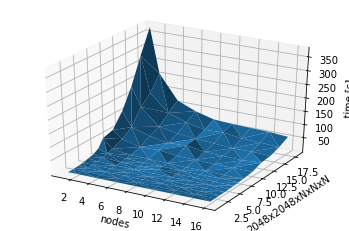

In [14]:
d = pd.DataFrame(by_imagesize('mpi').unstack().reset_index())
d.rename(columns={'level_0':'image_size', 0: 'time_ms'}, inplace=True)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(d['size'], d['image_size'], d['time_ms'] / 1000)
ax.set_xlabel('nodes')
ax.set_ylabel('2048x2048xNxNxN')
ax.set_zlabel('time [s]')
plt.savefig('figures/convolve_mpi_3d.pdf')
plt.show()

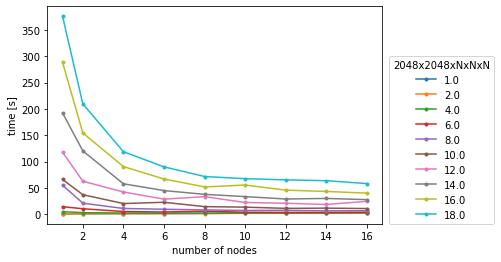

In [16]:
ds = (by_imagesize('mpi')/1000)
del ds[3]
del ds[5]
del ds[7]
ax = ds.plot(marker='.')
ax.set_ylabel('time [s]')
ax.set_xlabel('number of nodes')
ax.legend(loc=(1.02,0), title='2048x2048xNxNxN')
plt.savefig('figures/convolve_mpi_time.pdf', bbox_inches='tight')
#fix_labels(ax)

,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0
size,,,,,,,,,,
1,628.0,1032.0,4855.0,14384.0,55125.0,66073.0,117969.0,192396.0,288774.5,376081.0
2,936.0,933.0,3073.0,10425.0,21019.0,37118.0,62672.0,120299.0,154353.0,209623.0
4,1243.0,1046.0,2180.0,5207.0,10985.0,20372.0,42304.0,57866.0,90556.0,118816.0
6,1355.0,1230.0,1895.0,4243.0,9509.0,22720.0,28701.0,44954.0,66976.0,90043.0
8,1595.0,1377.0,1959.0,5849.0,8208.0,14491.0,33403.0,37797.0,51895.0,71692.0
10,1963.0,1804.0,2184.0,3788.0,7126.0,13501.0,22313.0,33512.0,55482.0,67536.0
12,2105.0,2025.0,2301.0,3550.0,7522.0,11201.0,20933.0,28922.0,45778.0,65288.0
14,2503.0,2138.0,2545.0,3484.0,6439.0,11594.0,18525.0,30035.0,43309.0,63716.0
16,2667.0,2496.0,2634.0,3937.0,6788.0,10848.0,24525.0,27769.0,40085.0,58239.0


,1.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,ideal
size,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,0.670940,1.106109,1.579889,1.379760,2.622627,1.780080,1.882324,1.599315,1.870871,1.794083,2
4,0.505229,0.986616,2.227064,2.762435,5.018207,3.243324,2.788602,3.324854,3.188905,3.165239,4
6,0.463469,0.839024,2.562005,3.390054,5.797140,2.908143,4.110275,4.279842,4.311612,4.176682,6
8,0.393730,0.749455,2.478305,2.459224,6.716009,4.559589,3.531689,5.090245,5.564592,5.245788,8
10,0.319918,0.572062,2.222985,3.797254,7.735756,4.893934,5.287008,5.741108,5.204832,5.568600,10
12,0.298337,0.509630,2.109952,4.051831,7.328503,5.898848,5.635552,6.652237,6.308150,5.760339,12
14,0.250899,0.482694,1.907662,4.128588,8.561112,5.698896,6.368097,6.405727,6.667771,5.902458,14
16,0.235471,0.413462,1.843204,3.653543,8.120949,6.090800,4.810153,6.928445,7.204054,6.457546,16


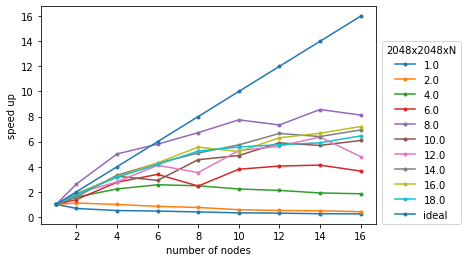

In [17]:
ds = by_imagesize('mpi')
del ds[3]
del ds[5]
del ds[7]
display(ds)
speedup = ds.iloc[0] / ds
speedup['ideal'] = [1] + list(range(2, 17, 2))
display(speedup)
ax = speedup.plot(marker='.')
ax.set_ylabel('speed up')
ax.set_xlabel('number of nodes')
ax.legend(loc=(1.02,0), title='2048x2048xN')
plt.savefig('figures/convolve_mpi_speedup.pdf', bbox_inches='tight')

# MPI Gahering time

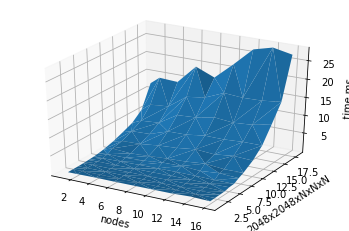

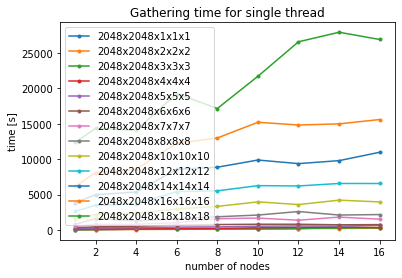

In [8]:
d = pd.DataFrame(by_imagesize('mpi', stat='gather').unstack().reset_index())
d.rename(columns={'level_0':'image_size', 0: 'time_ms'}, inplace=True)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(d['size'], d['image_size'], d['time_ms'] / 1000)
ax.set_xlabel('nodes')
ax.set_ylabel('2048x2048xNxNxN')
ax.set_zlabel('time ms')
plt.savefig('figures/convolve_mpi_gathertime.pdf')
plt.show()


ax = by_imagesize('mpi', stat='gather').plot(marker='.', title='Gathering time for single thread')
ax.set_ylabel('time [s]')
ax.set_xlabel('number of nodes')
fix_labels(ax)

In [9]:
data[(data['stat'] == 'barrier') & (data['method'] == 'mpi')]['time_ms'].describe()

count      958.000000
mean      1091.755741
std       2044.421019
min          0.000000
25%        121.750000
50%        316.000000
75%       1199.750000
max      30498.000000
Name: time_ms, dtype: float64

In [10]:
by_imagesize('mpi', stat='barrier').describe([0.95])

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,14.0,16.0,18.0
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,346.333333,256.777778,201.000000,249.111111,319.555556,785.777778,570.888889,675.666667,1793.888889,4663.888889,6478.888889,4259.277778,2777.444444
std,203.271370,197.235125,147.100306,136.528792,189.927033,777.894880,472.772790,455.794636,2292.898572,4205.177090,9194.682736,3021.623230,1872.201452
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,327.000000,174.000000,221.000000,268.000000,325.000000,468.000000,405.000000,800.000000,984.000000,3198.000000,3665.000000,3673.000000,2543.000000
95%,622.000000,504.000000,416.200000,403.000000,557.600000,2156.400000,1372.800000,1287.000000,5372.800000,10848.800000,20684.000000,9114.200000,5712.400000
max,702.000000,558.000000,431.000000,419.000000,588.000000,2344.000000,1480.000000,1345.000000,7714.000000,11982.000000,30498.000000,9937.000000,6402.000000


In [11]:
by_imagesize('mpi', stat='read').describe([0.95])

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,14.0,16.0,18.0
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,208.888889,567.888889,1183.222222,2465.333333,4697.222222,9137.111111,3956.388889,5903.055556,12060.777778,18901.222222,31122.888889,74500.055556,67198.444444
std,16.601539,112.020583,211.393459,331.210281,986.942599,2300.717141,2721.555780,3335.503733,7008.221275,9073.861895,21017.309684,64131.597324,27190.305589
min,194.000000,511.000000,1083.000000,2318.000000,4301.000000,7088.000000,2645.000000,3899.000000,6352.000000,11443.000000,16840.000000,26174.000000,37215.000000
50%,204.000000,536.000000,1117.000000,2362.000000,4382.000000,7336.000000,2826.000000,4013.000000,8979.000000,12499.000000,26183.000000,50478.500000,59559.000000
95%,236.200000,737.000000,1504.000000,2970.200000,6177.200000,12200.400000,8676.000000,11801.100000,23220.400000,32549.400000,66448.200000,176359.800000,107660.000000
max,247.000000,865.000000,1744.000000,3345.000000,7326.000000,12602.000000,10799.000000,12480.500000,23964.000000,35321.000000,82641.000000,227573.000000,113338.000000


## Dataset read time

,1,2,3,4,5,6,7,8,10,12,14,16,18
size,,,,,,,,,,,,,
1,0.194,0.515,1.084,2.322,4.387,12.602,2.6450,3.9450,23.964,24.468,82.641,50.4785,113.338
2,0.197,0.511,1.102,2.318,4.403,7.088,2.6470,3.8990,6.352,12.499,16.840,26.1740,37.215
4,0.196,0.528,1.083,2.324,4.304,7.248,2.7000,3.9860,6.859,28.392,17.365,35.3090,48.906
6,0.205,0.538,1.114,2.362,4.301,7.336,2.8260,5.9090,8.979,12.018,17.246,227.5730,37.911
8,0.204,0.545,1.119,2.408,4.348,11.249,2.8440,3.9550,10.345,11.443,19.695,99.5400,84.913
10,0.203,0.530,1.117,2.375,4.454,11.598,2.8400,10.7820,16.578,22.878,30.982,32.0120,72.980
12,0.220,0.536,1.142,2.374,4.382,7.254,5.4915,4.1580,6.708,11.570,26.183,82.4750,50.821
14,0.214,0.543,1.144,2.360,4.370,7.320,2.8150,4.0130,6.657,11.522,26.995,26.7410,59.559
16,0.247,0.865,1.744,3.345,7.326,10.539,10.7990,12.4805,22.105,35.321,42.159,90.1980,99.143


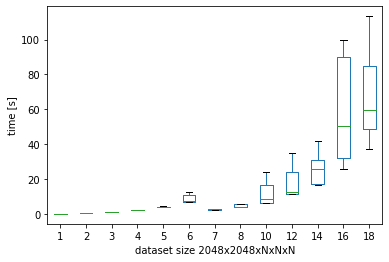

In [12]:
ds = (by_imagesize('mpi', stat='read') / 1000)
ds.columns = ds.columns.astype('int')
ax = ds.plot.box(sym='')
ax.set_ylabel('time [s]')
ax.set_xlabel('dataset size 2048x2048xNxNxN')
plt.savefig('figures/io_read.pdf')
ds